## Fixed Effects Model

Fixed Effects Model assumes that patterns within each country are unique and do not generalize across countries. It controls for all time-invariant differences between the countries, so the estimated coefficients of the fixed-effects models cannot be biased because of omitted time-invariant characteristics. This is useful in our case as there are many unobserved country-specific factors (like culture, geography, etc.) that could influence child mortality but are hard to measure or include in the model.

In [242]:
from linearmodels.panel import PanelOLS
import pandas as pd

final_df = pd.read_csv('../data/modeling/input_data.csv')
final_df = final_df.set_index(['Country Name', 'Year'])

final_df.head()

Mortality rate under-5  GDP per capita  \
Country Name Year                                           
Afghanistan  2000                   131.7     1617.826475   
             2001                   127.4     1454.110782   
             2002                   123.1     1774.308743   
             2003                   118.7     1815.928200   
             2004                   114.2     1776.918207   

                   Population density (people per sq. km of land area)  \
Country Name Year                                                        
Afghanistan  2000                                          30.863847     
             2001                                          31.099929     
             2002                                          32.776961     
             2003                                          34.854344     
             2004                                          36.123230     

                  Income classification  log_gdp_per_capita  \
Country Name Year                                             
Afghanistan  2000                   Low           -2.230818   
             2001                   Low           -2.327831   
             2002                   Low           -2.146859   
             2003                   Low           -2.125774   
             2004                   Low           -2.145523   

                   log_population_density  log_mortality_rate_under_5  \
Country Name Year                                                       
Afghanistan  2000               -0.856783                    4.888091   
             2001               -0.850321                    4.855150   
             2002               -0.805740                    4.821088   
             2003               -0.753491                    4.784989   
             2004               -0.723046                    4.746670   

                   log_reflected_secondary_education  \
Country Name Year                                      
Afghanistan  2000                           6.024520   
             2001                           6.024520   
             2002                           5.209860   
             2003                           4.153918   
             2004                           4.892872   

                   log_reflected_dpt3_immunization  logit_water_services  \
Country Name Year                                                          
Afghanistan  2000                         2.683084             -1.551486   
             2001                         2.545223             -1.551040   
             2002                         2.495180             -1.518356   
             2003                         2.406403             -1.487741   
             2004                         2.226150             -1.458693   

                   sqrt_health_expenditure  boxcox_mortality  Income_High  
Country Name Year                                                          
Afghanistan  2000                 1.221384          1.758949        False  
             2001                 1.221384          1.743294        False  
             2002                 1.065546          1.726970        False  
             2003                 0.899279          1.709519        False  
             2004                 1.183673          1.690822        False

In [243]:

formula = """
boxcox_mortality ~ 1 + log_gdp_per_capita
+ log_gdp_per_capita : Income_High
+ sqrt_health_expenditure + log_reflected_dpt3_immunization
+ log_reflected_secondary_education + logit_water_services
+ log_population_density
+ EntityEffects + TimeEffects
"""

fe_model = PanelOLS.from_formula(formula, data=final_df)
results = fe_model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       boxcox_mortality   R-squared:                        0.1805
Estimator:                   PanelOLS   R-squared (Between):              0.0534
No. Observations:                1760   R-squared (Within):               0.0161
Date:                Wed, Oct 15 2025   R-squared (Overall):              0.0510
Time:                        17:36:57   Log-likelihood                    1293.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      51.968
Entities:                          80   P-value                           0.0000
Avg Obs:                       22.000   Distribution:                  F(7,1652)
Min Obs:                       22.000                                           
Max Obs:                       22.000   F-statistic (robust):             2.9076
                            

Since the p-value corresponding to the robust f-statistic <0.05, we have strong evidence that, collectively, the explanatory variables in the model (including GDP, its interactions, and the control variables) have a statistically significant effect on child mortality, after controlling for country-specific and year-specific fixed effects.

## Random Effects Model

Random Effects Model assumes that individual country effects are uncorrelated with the explanatory variables. This allows for the inclusion of time-invariant variables, which is not possible in fixed effects models. This is useful in our case as some country-specific factors that influence child mortality might be constant over time (like geography) and we want to include them in the model.

In [244]:
from linearmodels import RandomEffects

formula = """
boxcox_mortality ~ 1 + log_gdp_per_capita
+ log_gdp_per_capita : Income_High
+ sqrt_health_expenditure + log_reflected_dpt3_immunization
+ log_reflected_secondary_education + logit_water_services
+ log_population_density
+ TimeEffects
"""

re_model = RandomEffects.from_formula(formula, data=final_df)
results = re_model.fit(cov_type='clustered')
print(results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:       boxcox_mortality   R-squared:                        0.6403
Estimator:              RandomEffects   R-squared (Between):              0.7994
No. Observations:                1760   R-squared (Within):               0.6187
Date:                Wed, Oct 15 2025   R-squared (Overall):              0.7878
Time:                        17:36:57   Log-likelihood                    700.66
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      445.62
Entities:                          80   P-value                           0.0000
Avg Obs:                       22.000   Distribution:                  F(7,1752)
Min Obs:                       22.000                                           
Max Obs:                       22.000   F-statistic (robust):             351.50
                            

In [245]:
from linearmodels.panel import compare

# Compare the models using Hausman test
comparison = compare({'Fixed Effects': fe_model.fit(cov_type='clustered', cluster_entity=True),
                      'Random Effects': re_model.fit(cov_type='clustered')})
print(comparison)

                                Model Comparison                               
                                             Fixed Effects       Random Effects
-------------------------------------------------------------------------------
Dep. Variable                             boxcox_mortality     boxcox_mortality
Estimator                                         PanelOLS        RandomEffects
No. Observations                                      1760                 1760
Cov. Est.                                        Clustered            Clustered
R-squared                                           0.1805               0.6403
R-Squared (Within)                                  0.0161               0.6187
R-Squared (Between)                                 0.0534               0.7994
R-Squared (Overall)                                 0.0510               0.7878
F-statistic                                         51.968               445.62
P-value (F-stat)                        

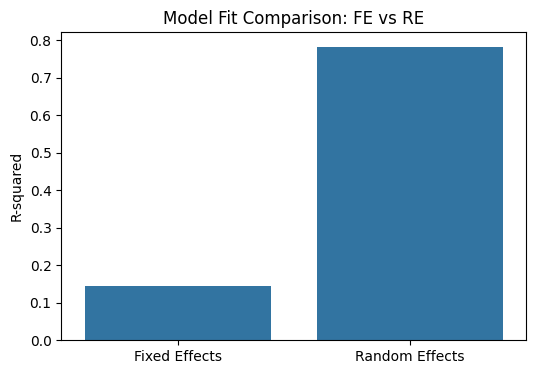

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.barplot(x=['Fixed Effects', 'Random Effects'], y=[0.1447, 0.7818])
plt.ylabel("R-squared")
plt.title("Model Fit Comparison: FE vs RE")
plt.show()

## Hausman Test

Below we compare the fixed effects and random effects models using Hausman test to see which is more suitable to use

In [247]:
import numpy as np
from scipy import stats

# 1️⃣ Fit models once
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)
re_results = re_model.fit(cov_type='clustered')

# 2️⃣ Select common regressors (exclude EntityEffects/TimeEffects)
common_vars = ['log_gdp_per_capita', 'log_gdp_per_capita:Income_High', 
               'sqrt_health_expenditure', 'log_reflected_dpt3_immunization',
               'log_reflected_secondary_education', 'logit_water_services', 'log_population_density']

b_fe = fe_results.params[common_vars]
b_re = re_results.params[common_vars]

V_fe = fe_results.cov.loc[common_vars, common_vars]
V_re = re_results.cov.loc[common_vars, common_vars]

# 3️⃣ Hausman statistic
diff = b_fe - b_re
V_diff = V_fe - V_re

# Use pseudo-inverse in case V_diff is singular
H = diff.values @ np.linalg.pinv(V_diff.values) @ diff.values
df = len(diff)
p_value = 1 - stats.chi2.cdf(H, df)

print(f"Hausman test statistic: {H:.4f}")
print(f"Degrees of freedom: {df}")
print(f"P-value: {p_value:.4f}")


Hausman test statistic: 79.4424
Degrees of freedom: 7
P-value: 0.0000


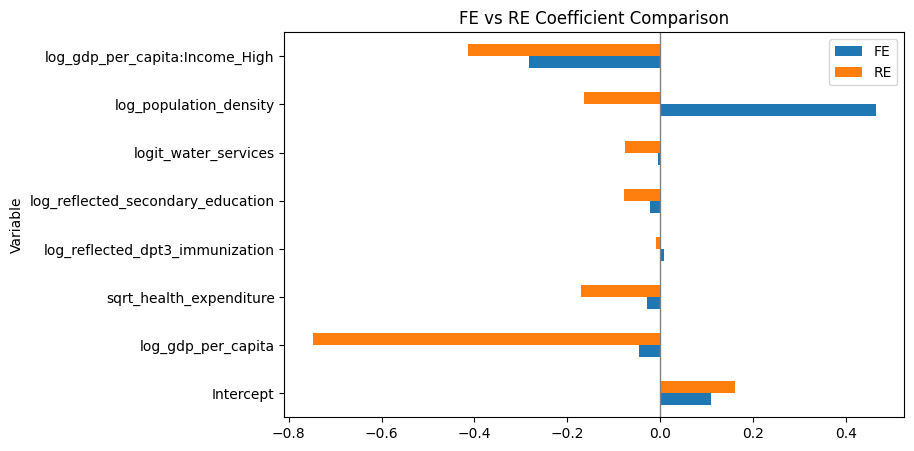

In [248]:
fe_res = fe_model.fit()
re_res = re_model.fit()
coef_comparison = pd.DataFrame({
    'Variable': fe_res.params.index,
    'FE': fe_res.params.values,
    'RE': re_res.params.values
}).set_index('Variable')

coef_comparison.plot(kind='barh', figsize=(8,5))
plt.title("FE vs RE Coefficient Comparison")
plt.axvline(0, color='grey', lw=1)


Since the Hausman test statistic is fairly high (79.4424), we can reject Random Effects in favor of Fixed Effects.
Since the p-value is 0.0000 (less than 0.05), we have strong evidence that the Fixed Effects model is more appropriate than the Random Effects model for our data.

## Adding more interactions to the Fixed Effects Model

In [249]:

formula = """
boxcox_mortality ~ 1 + log_gdp_per_capita
+ log_gdp_per_capita : Income_High
+ sqrt_health_expenditure 
+ sqrt_health_expenditure : log_population_density
+ sqrt_health_expenditure : Income_High
+ log_reflected_dpt3_immunization
+ log_reflected_dpt3_immunization : Income_High
+ log_reflected_dpt3_immunization : log_population_density
+ log_reflected_secondary_education
+ log_reflected_secondary_education : log_population_density
+ logit_water_services : log_population_density
+ log_population_density
+ EntityEffects + TimeEffects
"""

fe_model_version_2 = PanelOLS.from_formula(formula, data=final_df)
results = fe_model_version_2.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       boxcox_mortality   R-squared:                        0.2204
Estimator:                   PanelOLS   R-squared (Between):              0.1530
No. Observations:                1760   R-squared (Within):               0.0593
Date:                Wed, Oct 15 2025   R-squared (Overall):              0.1469
Time:                        17:36:57   Log-likelihood                    1336.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      38.793
Entities:                          80   P-value                           0.0000
Avg Obs:                       22.000   Distribution:                 F(12,1647)
Min Obs:                       22.000                                           
Max Obs:                       22.000   F-statistic (robust):             3.7612
                            

## Mundlak Approach

In [250]:
# Assuming 'Country Name' and 'Year' are your panel identifiers
panel_vars = ['Country Name', 'Year']
df = final_df.sort_values(panel_vars)

# Lagged variables (lag 1 year)
df['log_gdp_per_capita_lag1'] = df.groupby('Country Name')['log_gdp_per_capita'].shift(1)
df['sqrt_health_expenditure_lag1'] = df.groupby('Country Name')['sqrt_health_expenditure'].shift(1)
df['log_reflected_dpt3_immunization_lag1'] = df.groupby('Country Name')['log_reflected_dpt3_immunization'].shift(1)
df['log_population_density_lag1'] = df.groupby('Country Name')['log_population_density'].shift(1)
df['logit_water_services_lag1'] = df.groupby('Country Name')['logit_water_services'].shift(1)

In [251]:
# Entity means
df['log_gdp_mean'] = df.groupby('Country Name')['log_gdp_per_capita'].transform('mean')
df['sqrt_health_expenditure_mean'] = df.groupby('Country Name')['sqrt_health_expenditure'].transform('mean')
df['log_reflected_dpt3_immunization_mean'] = df.groupby('Country Name')['log_reflected_dpt3_immunization'].transform('mean')
df['log_population_density_mean'] = df.groupby('Country Name')['log_population_density'].transform('mean')
df['logit_water_services_mean'] = df.groupby('Country Name')['logit_water_services'].transform('mean')

In [252]:
formula = """
boxcox_mortality ~ 1
+ log_gdp_per_capita_lag1
+ log_gdp_per_capita_lag1 : Income_High
+ sqrt_health_expenditure_lag1
+ sqrt_health_expenditure_lag1 : log_population_density_lag1
+ sqrt_health_expenditure_lag1 : Income_High
+ log_reflected_dpt3_immunization_lag1
+ log_reflected_dpt3_immunization_lag1 : Income_High
+ log_reflected_dpt3_immunization_lag1 : log_population_density_lag1
+ log_reflected_secondary_education
+ log_reflected_secondary_education : log_population_density_lag1
+ logit_water_services_mean
+ logit_water_services_lag1 : log_population_density_lag1
+ log_population_density_mean
+ log_gdp_mean
+ sqrt_health_expenditure_mean
+ log_reflected_dpt3_immunization_mean
+ TimeEffects
"""

fe_model_mundlak = PanelOLS.from_formula(formula, data=df)
results = fe_model_mundlak.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       boxcox_mortality   R-squared:                        0.8893
Estimator:                   PanelOLS   R-squared (Between):              0.9079
No. Observations:                1680   R-squared (Within):               0.2968
Date:                Wed, Oct 15 2025   R-squared (Overall):              0.8724
Time:                        17:36:57   Log-likelihood                   -500.76
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      824.82
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                 F(16,1643)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             69.413
                            

/Users/shreyasriram/sdg-modeling/sustainable-development-goals-modeling/venv/lib/python3.11/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [253]:
coef = results.params

slope_low = coef['log_gdp_per_capita_lag1']
slope_high = slope_low + coef['log_gdp_per_capita_lag1:Income_High']

print(f"Income_Low slope: {slope_low:.3f}")
print(f"Income_High slope: {slope_high:.3f}")

Income_Low slope: -0.248
Income_High slope: -0.327


R^2 (Overall) has jumped from 0.0510 (the first FE model fit) to 0.8724 indicating a much better fit with the Mundlak approach.
Mundlak approach is able to account for some of the entity-specific effects better by including lag terms for gdp, health expenditure, and DPT3 immunization along with using their means as additional predictors.

However the slopes for low income are much lower than those for high income but the p-value of `log_gdp_per_capita_lag1:Income_High` is over 0.05 so we are not conclusively able to accept or reject the null hypothesis so trying an alternate approach.

## Hierarachical panel model

In [254]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure categorical variables are coded properly
final_df = pd.read_csv('../data/modeling/input_data.csv')
final_df['Income classification'] = final_df['Income classification'].astype('category')
final_df['Country Name'] = final_df['Country Name'].astype('category')

# Lagged variables (lag 1 year)
final_df['log_gdp_per_capita_lag1'] = final_df.groupby('Country Name')['log_gdp_per_capita'].shift(1)
final_df['sqrt_health_expenditure_lag1'] = final_df.groupby('Country Name')['sqrt_health_expenditure'].shift(1)
final_df['log_reflected_dpt3_immunization_lag1'] = final_df.groupby('Country Name')['log_reflected_dpt3_immunization'].shift(1)
final_df['log_population_density_lag1'] = final_df.groupby('Country Name')['log_population_density'].shift(1)
print(len(final_df))

1760


/var/folders/yk/c0cfqj715njfdnphhzw8m5p00000gn/T/ipykernel_71775/2235807662.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df['log_gdp_per_capita_lag1'] = final_df.groupby('Country Name')['log_gdp_per_capita'].shift(1)
/var/folders/yk/c0cfqj715njfdnphhzw8m5p00000gn/T/ipykernel_71775/2235807662.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df['sqrt_health_expenditure_lag1'] = final_df.groupby('Country Name')['sqrt_health_expenditure'].shift(1)
/var/folders/yk/c0cfqj715njfdnphhzw8m5p00000gn/T/ipykernel_71775/2235807662.py:12: FutureWarning: The default of observed=False is deprecated an

In [255]:
# Random intercept & slope by Income group
formula = "boxcox_mortality ~ log_gdp_per_capita_lag1 + sqrt_health_expenditure_lag1 + log_reflected_dpt3_immunization_lag1 + log_reflected_secondary_education"

# groups = Income_group allows us to have random effects by income
# re_formula = "1 + log_gdp_per_capita_lag1" allows GDP slope to vary
df_clean = final_df.dropna(subset=[
    'log_gdp_per_capita_lag1',
    'sqrt_health_expenditure_lag1',
    'log_reflected_dpt3_immunization_lag1',
    'log_reflected_secondary_education',
    'boxcox_mortality',
    'Income classification'
])
print(len(df_clean))

model = smf.mixedlm(formula, df_clean, groups=df_clean["Income classification"], re_formula="1 + log_gdp_per_capita_lag1")
result = model.fit(reml=False)

print(result.summary())

1680
                     Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       boxcox_mortality
No. Observations:       1680          Method:                   ML              
No. Groups:             2             Scale:                    0.1252          
Min. group size:        732           Log-Likelihood:           -645.9535       
Max. group size:        948           Converged:                No              
Mean group size:        840.0                                                   
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                            -0.195    0.274  -0.712 0.477 -0.731  0.342
log_gdp_per_capita_lag1              -0.452    0.121  -3.753 0.000 -0.689 -0.216
sqrt_health_expenditure_lag1         -0.221  

/Users/shreyasriram/sdg-modeling/sustainable-development-goals-modeling/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shreyasriram/sdg-modeling/sustainable-development-goals-modeling/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/shreyasriram/sdg-modeling/sustainable-development-goals-modeling/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shreyasriram/sdg-modeling/sustainable-development-goals-modeling/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying Mix

In [256]:
# Random effects for each income group
re = result.random_effects
for group, effects in re.items():
    print(f"Income group: {group}")
    print(effects)


Income group: High
Group                     -0.360317
log_gdp_per_capita_lag1    0.155954
dtype: float64
Income group: Low
Group                      0.360317
log_gdp_per_capita_lag1   -0.155954
dtype: float64


In [257]:
fixed_slope = result.fe_params['log_gdp_per_capita_lag1']

group_slopes = {}
for group, effects in re.items():
    group_slopes[group] = fixed_slope + effects['log_gdp_per_capita_lag1']

print("GDP effect by income group:")
for group, slope in group_slopes.items():
    print(f"{group}: {slope:.3f}")


GDP effect by income group:
High: -0.296
Low: -0.608


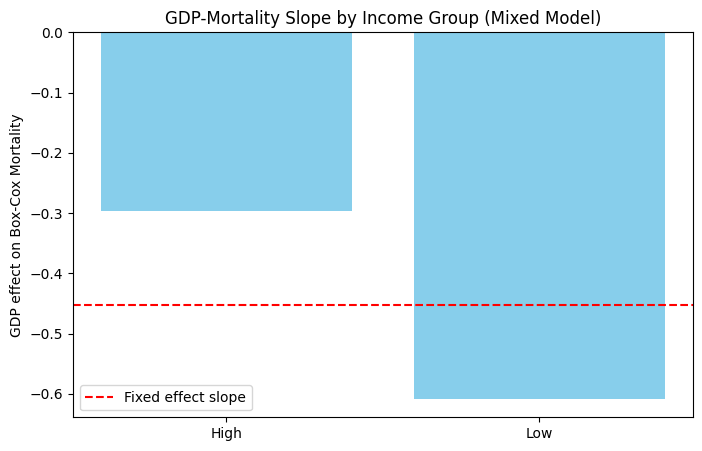

In [258]:
import matplotlib.pyplot as plt

groups = list(group_slopes.keys())
slopes = [group_slopes[g] for g in groups]

plt.figure(figsize=(8,5))
plt.bar(groups, slopes, color='skyblue')
plt.axhline(fixed_slope, color='red', linestyle='--', label='Fixed effect slope')
plt.ylabel("GDP effect on Box-Cox Mortality")
plt.title("GDP-Mortality Slope by Income Group (Mixed Model)")
plt.legend()
plt.show()


Low income is steeper than the dashed line indicating a stronger mortality reduction per unit increase compared to High income.

Calculating the confidence intervals for the slopes for low income and high income

In [259]:
import numpy as np

# Fixed effect slope of GDP
beta_gdp = result.params['log_gdp_per_capita_lag1']
se_beta = result.bse['log_gdp_per_capita_lag1']

# Random effect variance for GDP slope across groups
var_gdp_random = result.cov_re.loc['log_gdp_per_capita_lag1', 'log_gdp_per_capita_lag1']

# For high-income group , slope = fixed effect
high_slope = beta_gdp
high_se = se_beta  # SE of fixed effect
high_ci = (high_slope - 1.96*high_se, high_slope + 1.96*high_se)

# Extract the random effect for low-income group
low_group = 'Low'  # Make sure this matches your group label in df_clean
low_random = result.random_effects[low_group]['log_gdp_per_capita_lag1']

low_slope = beta_gdp + low_random

# Standard error approximation: combine fixed and random variances
low_se = np.sqrt(se_beta**2 + var_gdp_random)
low_ci = (low_slope - 1.96*low_se, low_slope + 1.96*low_se)

print(f"High-income slope: {high_slope:.3f}, 95% CI: {high_ci}")
print(f"Low-income slope: {low_slope:.3f}, 95% CI: {low_ci}")


High-income slope: -0.452, 95% CI: (np.float64(-0.6886705509310754), np.float64(-0.21613949952468012))
Low-income slope: -0.608, 95% CI: (np.float64(-1.0159368985314612), np.float64(-0.20078083072314662))


## Scale the predictors back to inputs to quantify the impact in the original scale

In [261]:
import numpy as np

# Box-Cox lambda (replace with your actual λ)
lambda_bc = -0.1992 # from exploratory_data_analysis.ipynb
# Current mortality (can also take mean per income group)
mortality_current_low = 37.26
mortality_current_high = 5.05

gdp_pct_increase = 10 # ballpark figure
delta_log_gdp = np.log(1 + gdp_pct_increase/100)

# Function to back-transform Box-Cox (if λ != 0)
def boxcox_inverse(y_star, lmbda):
    if lmbda == 0:
        return np.exp(y_star)
    else:
        return np.power(lmbda * y_star + 1, 1/lmbda)
 
# Step 1: Estimate change in Box-Cox space
delta_y_low = slope_low * delta_log_gdp
delta_y_high = slope_high * delta_log_gdp

# Step 2: Convert current mortality to Box-Cox space
def to_boxcox_log(mortality, lmbda):
    y = np.log(mortality)
    if lmbda == 0:
        return y
    else:
        return (mortality**lmbda - 1)/lmbda

y_star_low = to_boxcox_log(mortality_current_low, lambda_bc)
y_star_high = to_boxcox_log(mortality_current_high, lambda_bc)

# Step 3: Apply delta in Box-Cox space
y_star_low_new = y_star_low + delta_y_low
y_star_high_new = y_star_high + delta_y_high

# Step 4: Back-transform to actual mortality
mortality_low_new = boxcox_inverse(y_star_low_new, lambda_bc)
mortality_high_new = boxcox_inverse(y_star_high_new, lambda_bc)

# Step 5: Compute absolute and percent change
abs_change_low = mortality_low_new - mortality_current_low
abs_change_high = mortality_high_new - mortality_current_high

pct_change_low = abs_change_low / mortality_current_low * 100
pct_change_high = abs_change_high / mortality_current_high * 100

print(f"Low-income: mortality change = {abs_change_low:.2f}, percent change = {pct_change_low:.1f}%")
print(f"High-income: mortality change = {abs_change_high:.2f}, percent change = {pct_change_high:.1f}%")


Low-income: mortality change = -1.76, percent change = -4.7%
High-income: mortality change = -0.21, percent change = -4.2%


The interpretation of the above is that a 10% increase in GDP per capita is associated with approximately 1,760 fewer child deaths per 1,000,000 in low-income countries and 210 fewer deaths per 1,000,000 in high-income countries.

In other words, a 10% rise in GDP per capita — a proxy for national income — prevents roughly eight times more child deaths in poorer economies.

This corresponds to about a 4.7% reduction in under-5 mortality in low-income countries and 4.2% in high-income countries. The relatively high percentage reduction in high-income countries reflects their lower baseline mortality, meaning that even small absolute improvements translate to larger proportional gains.

TODO can calculate confidence intervals for the above values!